<a href="https://colab.research.google.com/github/frantz18/NLP-project/blob/main/NLP_PROJECT_LeHelloco_Strub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**NLP PROJECT**
#**Predicting genres and success from song lyrics**
Le Helloco François - Strub Thomas

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv 
%matplotlib inline

import string
import tensorflow as tf
import keras
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence, text
from keras.metrics import Recall
import json
import sklearn
from sklearn import preprocessing as skpp



##**0. Data Pre-Processing**

First, we import the cleaned english lyrics data.

In [ ]:
#! wget https://github.com/frantz18/NLP-project/blob/main/new_english_cleaned_lyrics.zip

We faced a problem while unpacking the data : the compressed database is not considered as a .zip file with both methods.\
In that respect, the data should be imported manually.

In [ ]:
#import shutil

#shutil.unpack_archive("new_english_cleaned_lyrics.zip")

In [ ]:
#from zipfile import ZipFile 
#zip = ZipFile('/content/new_english_cleaned_lyrics.zip', mode='r')
#zip.extract('english_cleaned_lyrics.csv', '')
 
#zip.close()

In [ ]:
path = 'english_cleaned_lyrics.csv'
data_genre = pd.read_csv(path, skip_blank_lines=False)
data_genre.head()

,Unnamed: 0,index,song,year,artist,genre,lyrics
0,0,0,ego-remix,2009,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut r...
1,1,1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem s...
2,2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,3,3,you-are-my-rock,2009,beyonce-knowles,Pop,Oh oh oh I oh oh oh I If I wrote a book about ...
4,4,4,black-culture,2009,beyonce-knowles,Pop,Party the people the people the party it's pop...


In [ ]:
data_genre.shape

(218210, 7)

We create a 100 song random subset in order to create manually a measure of success for each song.
Success will be captures using :
- the Spotify number of streams
- the Deezer rate
- the Youtube number of views

In [ ]:
data_genre_1 = data_genre[['index', 'song', 'year', 'artist', 'genre', 'lyrics']]
data_100songs = data_genre_1.sample(n=100) # select randomly 100 songs 
data_100songs.to_excel('100songs.xlsx')

We then import the success database fully completed.

In [ ]:
#! wget https://github.com/frantz18/NLP-project/blob/main/100songs_rempli_final.csv

As before, importing data from our github does not seem to work. In that respect, data should be imported manually.

In [ ]:
path = '100songs_rempli_final.csv'
data_success = pd.read_csv(path, sep= ';', skip_blank_lines=False)
data_success.head()

,index,song,year,artist,genre,lyrics,spotify_streams,deezer_rate,youtube_views
0,248635,live-for-the-one-you-love,2008,celine-dion,Pop,A million stars light This beautiful night Thi...,1724337.0,"3,03",104000
1,117972,perfection,2006,bonnie-tyler,Pop,desmond child diane warren Producer for bonni...,NaN,NaN,18000
2,362048,watch-this,2006,clay-walker,Country,If you've never felt what happens When two hea...,751902.0,"1,45",301000
3,316112,stormy-ballad-of-a-vampire,2008,blind-iris,Rock,Stormy says the sun is too bright She sleeps i...,1000.0,"0,31",43
4,23395,the-revelation-embodied,2007,cult-of-luna,Rock,A time lost to the sick crowd of a new demonic...,117748.0,"0,86",2300


##**1. Data Analysis**

In [ ]:
data = data_genre

In [ ]:
data.head()

,Unnamed: 0,index,song,year,artist,genre,lyrics
0,0,0,ego-remix,2009,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut r...
1,1,1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem s...
2,2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,3,3,you-are-my-rock,2009,beyonce-knowles,Pop,Oh oh oh I oh oh oh I If I wrote a book about ...
4,4,4,black-culture,2009,beyonce-knowles,Pop,Party the people the people the party it's pop...


In [ ]:
data.shape

(218210, 7)

In [ ]:
data_lyrics = data[['index', 'song', 'year', 'artist', 'genre', 'lyrics']]

In [ ]:
data_lyrics.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,Oh baby how you doing You know I'm gonna cut r...
1,1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem s...
2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,Oh oh oh I oh oh oh I If I wrote a book about ...
4,4,black-culture,2009,beyonce-knowles,Pop,Party the people the people the party it's pop...


In [ ]:
data_lyrics.dtypes

index      int64
song      object
year       int64
artist    object
genre     object
lyrics    object
dtype: object

In [ ]:
data_lyrics["lyrics"] = data_lyrics["lyrics"].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
data_lyrics["genre"].value_counts(normalize=True)

Rock          0.458517
Pop           0.156441
Hip-Hop       0.103817
Metal         0.097200
Country       0.064882
Jazz          0.033500
Electronic    0.031813
Other         0.017350
R&B           0.015288
Indie         0.013450
Folk          0.007740
Name: genre, dtype: float64

Rock is predominant in the dataset, followed by Pop and Hip-Hop

In [ ]:
data_lyrics["genre"].value_counts()

Rock          100053
Pop            34137
Hip-Hop        22654
Metal          21210
Country        14158
Jazz            7310
Electronic      6942
Other           3786
R&B             3336
Indie           2935
Folk            1689
Name: genre, dtype: int64

In [ ]:
data_lyrics['lyrics'] = data_lyrics['lyrics'].str.lower()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
#number of words in the vocabulary 

from nltk.tokenize.regexp import WhitespaceTokenizer 
#let's tokenise the lyrics 
#by using a tokeniser which uses non-alphabetical characters as a separator
#so as to count words

data_lyrics['nb of words'] = 0
data_lyrics['unique words'] = 0

for i in data_lyrics.index:
  tokens = WhitespaceTokenizer().tokenize(data_lyrics['lyrics'][i])
  data_lyrics['nb of words'][i] = len(tokens)
  data_lyrics['unique words'][i] = len(set(tokens))

# actually it is more a token counts, since
# it gives a word and punctuation count. But punctuation has been removed
# then it is ok 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
data_lyrics.head(2)

,index,song,year,artist,genre,lyrics,nb of words,unique words
0,0,ego-remix,2009,beyonce-knowles,Pop,oh baby how you doing you know i'm gonna cut r...,433,137
1,1,then-tell-me,2009,beyonce-knowles,Pop,playin everything so easy it's like you seem s...,258,121


In [ ]:
data_lyrics['nb of words'].describe()

count    218210.000000
mean        233.469273
std         157.148181
min           1.000000
25%         134.000000
50%         195.000000
75%         283.000000
max        5131.000000
Name: nb of words, dtype: float64

The average number of 'words'/tokens per song is about 230.\
The variance is high, the standard deviation is approximately 157.\

Let's see the difference between the genres :

In [ ]:
data_lyrics['unique words'].describe()

count    218210.000000
mean        100.316429
std          61.574979
min           1.000000
25%          65.000000
50%          86.000000
75%         113.000000
max        1124.000000
Name: unique words, dtype: float64

In [ ]:
grouped_genre = data_lyrics.groupby('genre')['nb of words'].mean().round(0).reset_index()
grouped_genre.sort_values('nb of words', ascending=False)

,genre,nb of words
3,Hip-Hop,494.0
8,Pop,250.0
9,R&B,226.0
7,Other,223.0
1,Electronic,205.0
2,Folk,201.0
4,Indie,199.0
10,Rock,196.0
0,Country,187.0
6,Metal,177.0


In [ ]:
grouped_genre2 = data_lyrics.groupby('genre')['unique words'].mean().round(0).reset_index()
grouped_genre2.sort_values('unique words', ascending=False)

,genre,unique words
3,Hip-Hop,211.0
2,Folk,94.0
7,Other,93.0
8,Pop,92.0
6,Metal,91.0
9,R&B,89.0
0,Country,88.0
4,Indie,87.0
10,Rock,86.0
1,Electronic,76.0


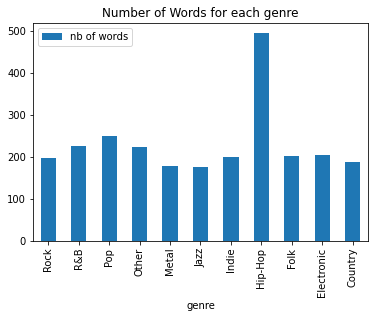

In [ ]:
grouped_genre.sort_values('genre', ascending=False).plot.bar(x='genre', y='nb of words', title='Number of Words for each genre');
plt.show()

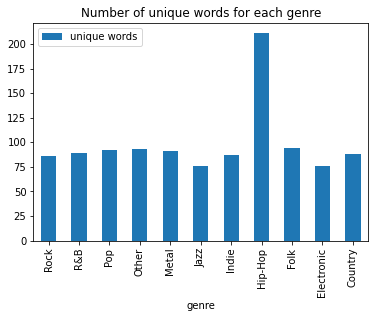

In [ ]:
grouped_genre2.sort_values('genre', ascending=False).plot.bar(x='genre', y='unique words', title='Number of unique words for each genre');
plt.show()

Interesting fact :
Hip Hop is distinctive as twice as many words as all the other genres.\
As far as lexical richness is concerned, it is quite the same.

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

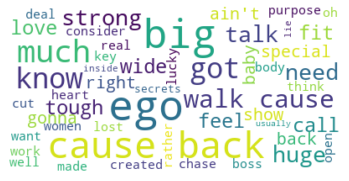

In [ ]:
# Start with one song:
text = data_lyrics['lyrics'][0]

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
lyrics_genre = data_lyrics.groupby('genre')['lyrics'].apply(''.join).reset_index()

In [ ]:
pd.options.display.max_colwidth = 100
#lyrics_genre.loc[lyrics_genre["genre"] == 'Country']['lyrics']
lyrics_genre

,genre,lyrics
0,Country,verse 1 when the last breath of life is gone from my body and my lips are as cold as the sea whe...
1,Electronic,reverse behold the finite set of thirteen convex figures the irrational sine versus tangent 45 ...
2,Folk,rise and fall like the tide my hand goes with your chest steady now moon will pull a slow and ev...
3,Hip-Hop,horns chorus timbo when you hit me on my phone betta know what cha want when you call me you al...
4,Indie,don't feel so bad it's just the way the wheel turns stay in where it's quiet and where the sick ...
5,Jazz,if i've had my way i'd leave here today i'd leave in a hurry i'd find me a place where i could s...
6,Metal,gods of the mountains sky forest and seas lands of fire ice and the northern deeps cold as a sto...
7,Other,a little thin band her finger left hand she's wearing my ring though not made of gold it tells ...
8,Pop,oh baby how you doing you know i'm gonna cut right to the chase some women were made but me myse...
9,R&B,little wallflower on the shelf standing by herself never had the nerve to take a chance so let ...


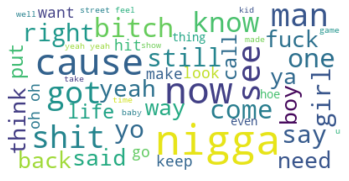

In [ ]:
# Word cloud for each genre 

#hip hop
lyrics_genre = data_lyrics.groupby('genre')['lyrics'].apply(','.join).reset_index()  
text = lyrics_genre['lyrics'][3]
wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="white").generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
wordcloud.to_file("Hip-hop-cloud.png")

##**2. Genre prediction**

We start by trying to predict the genre with data_genre.


In [ ]:
data = data_genre

We start with the tokenization.

In [ ]:
lyrics_data = data['lyrics'].values
max_words = 1000

# Create a new Tokenizer
tokenizer = text.Tokenizer(num_words=max_words, oov_token='<UNK>')
# Feed our song lyrics to the Tokenizer
tokenizer.fit_on_texts(lyrics_data)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)
    
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= max_words} # <= because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] = max_words + 1
indexed_data = tokenizer.texts_to_sequences(lyrics_data)
indexed_data = np.array(indexed_data)

label_encoder = skpp.LabelEncoder()
indexed_labels = np.array(label_encoder.fit_transform(data['genre'].values))


num_test = 30000

# Shuffle data before splitting off test set
random_indexes = np.random.permutation(len(indexed_labels))
indexed_data = indexed_data[random_indexes]
indexed_labels = indexed_labels[random_indexes]

X_train = indexed_data[:-num_test]
y_train = indexed_labels[:-num_test]
X_test  = indexed_data[-num_test:]
y_test  = indexed_labels[-num_test:]

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

num_words = max_words + 2
# Truncate and pad input sequences
max_review_length = 500

X_train_padded = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_padded = sequence.pad_sequences(X_test, maxlen=max_review_length)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Here is the correspondance of the labels and the genres.

In [ ]:
genre_str = label_encoder.inverse_transform(np.array([0,1,2,3,4,5,6,7,8,9,10]))
label_encoder.inverse_transform(np.array([0,1,2,3,4,5,6,7,8,9,10]))

array(['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Other', 'Pop', 'R&B', 'Rock'], dtype=object)

After some test with our training dataset, we faced too large computation time.\
That is why we decided to work with less data in order to be able to train more models.

In [ ]:
X_train_padded_small = X_train_padded[:-150000]
y_train_small = y_train[:-150000]

In [ ]:
X_test_padded_small = X_test_padded[:-25000]
y_test_small = y_test[:-25000]

After the tokenization, we will test two embedding techniques, FastText and GloVe.\
We then start by loading pre-trained models on common crawl.

In [ ]:
import requests, zipfile, io
zip_file_url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
import requests, zipfile, io
zip_file_url = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [ ]:
import requests, zipfile, io
zip_file_url = 'http://nlp.stanford.edu/data/glove.840B.300d.zip'
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

###**2.1. FastText Embedding**

We start with FastText Embedding :
We load the already trained model in order to create the Enbedding Matrix that will help us create our Embedding Layer when building the Bidirectional LSTM model.

In [ ]:
import codecs
from tqdm import tqdm
embeddings_index = {}
#f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8') #FastText trained on wikipedia 2017
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8') #FastText trained on common crawl
for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

1999996it [03:37, 9181.48it/s]


In [ ]:
word_index = tokenizer.word_index
MAX_NB_WORDS = 1000
embed_dim = 300

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
  if i >= nb_words:
     continue
  embedding_vector = embeddings_index.get(word)
  
  if (embedding_vector is not None) and len(embedding_vector) > 0:
     embedding_matrix[i] = embedding_vector
  else:
     words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 24


Now that the Embedding Matrix is created, we build the Bidirectional LSTM model.

In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf
from keras.layers import Dropout


# Hyperparameters
embedding_vector_length = 50

# Create the Bidirectional LSTM model with Keras
model = Sequential()
model.add(Embedding(num_words, embedding_vector_length, input_length=max_review_length))
model.add(Bidirectional(LSTM(60, return_sequences=True)))
model.add(GlobalMaxPooling1D())
model.add(Dense(11, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[
    'accuracy',
    Recall(class_id=0, name='recall_Country_0'),
    Recall(class_id=1, name='recall_Electronic_1'),
    Recall(class_id=2, name='recall_Folk_2'),
    Recall(class_id=3, name='recall_Hip_Hop_3'),
    Recall(class_id=4, name='recall_Indie_4'),
    Recall(class_id=5, name='recall_Jazz_5'),
    Recall(class_id=6, name='recall_Metal_6'),
    Recall(class_id=7, name='recall_Other_7'),
    Recall(class_id=8, name='recall_Pop_8'),
    Recall(class_id=9, name='recall_RB_9'),
    Recall(class_id=10, name='recall_Rock_10')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 50)           50100     
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 120)          53280     
_________________________________________________________________
global_max_pooling1d (Global (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 11)                1331      
Total params: 104,711
Trainable params: 104,711
Non-trainable params: 0
_________________________________________________________________
None


We then fit the model on the Train dataset.

In [ ]:
mod_metrics = model.fit(X_train_padded_small, y_train_small, batch_size=64, epochs=3)

Epoch 1/3
626/626 [==============================] - 392s 618ms/step - loss: 1.6868 - accuracy: 0.4972 - recall_Country_0: 0.0000e+00 - recall_Electronic_1: 0.0000e+00 - recall_Folk_2: 0.0000e+00 - recall_Hip_Hop_3: 0.2741 - recall_Indie_4: 0.0000e+00 - recall_Jazz_5: 0.0000e+00 - recall_Metal_6: 0.0388 - recall_Other_7: 0.0000e+00 - recall_Pop_8: 0.0000e+00 - recall_RB_9: 0.0000e+00 - recall_Rock_10: 0.4023
Epoch 2/3
626/626 [==============================] - 393s 628ms/step - loss: 1.3990 - accuracy: 0.5601 - recall_Country_0: 0.0000e+00 - recall_Electronic_1: 0.0000e+00 - recall_Folk_2: 0.0000e+00 - recall_Hip_Hop_3: 0.6674 - recall_Indie_4: 0.0000e+00 - recall_Jazz_5: 0.0000e+00 - recall_Metal_6: 0.3854 - recall_Other_7: 0.0000e+00 - recall_Pop_8: 4.4458e-04 - recall_RB_9: 0.0000e+00 - recall_Rock_10: 0.6674
Epoch 3/3
626/626 [==============================] - 392s 627ms/step - loss: 1.3521 - accuracy: 0.5715 - recall_Country_0: 0.0000e+00 - recall_Electronic_1: 0.0000e+00 - recall

After that, we predict the genres

In [ ]:
preds = model.predict(X_test_padded_small, batch_size=64)

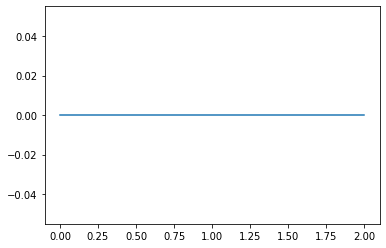

In [ ]:
plt.plot(mod_metrics.history['recall_Country_0'])
plt.show()

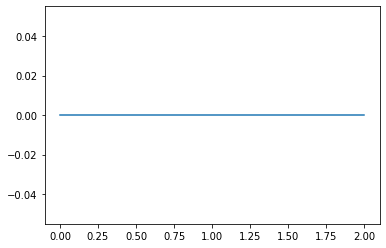

In [ ]:
plt.plot(mod_metrics.history['recall_Electronic_1'])
plt.show()

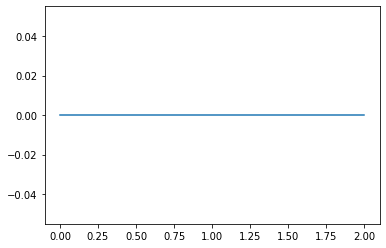

In [ ]:
plt.plot(mod_metrics.history['recall_Folk_2'])
plt.show()

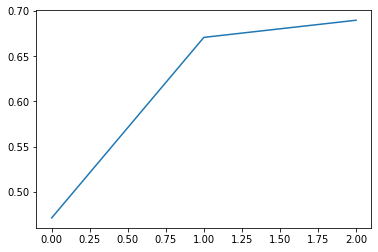

In [ ]:
plt.plot(mod_metrics.history['recall_Hip_Hop_3'])
plt.show()

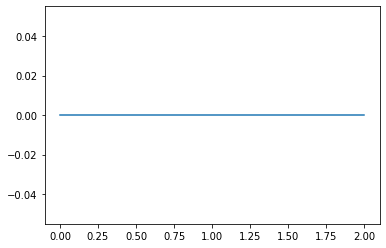

In [ ]:
plt.plot(mod_metrics.history['recall_Indie_4'])
plt.show()

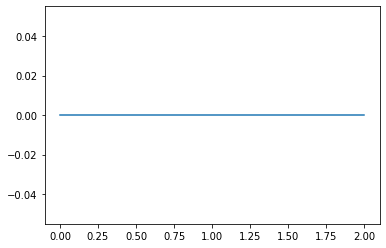

In [ ]:
plt.plot(mod_metrics.history['recall_Jazz_5'])
plt.show()

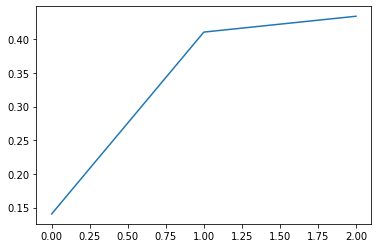

In [ ]:
plt.plot(mod_metrics.history['recall_Metal_6'])
plt.show()

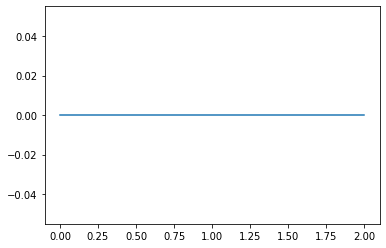

In [ ]:
plt.plot(mod_metrics.history['recall_Other_7'])
plt.show()

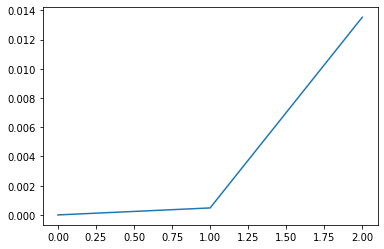

In [ ]:
plt.plot(mod_metrics.history['recall_Pop_8'])
plt.show()

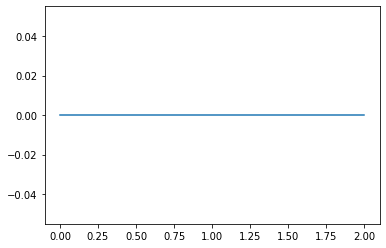

In [ ]:
plt.plot(mod_metrics.history['recall_RB_9'])
plt.show()

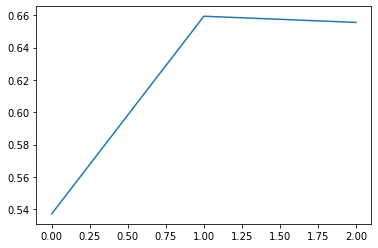

In [ ]:
plt.plot(mod_metrics.history['recall_Rock_10'])
plt.show()

and evaluate our error rate.

In [ ]:
preds_app = preds

In [ ]:
for i in range(preds_app.shape[0]):
  for j in range(preds_app.shape[1]):
    if max(preds_app[i,]) == preds_app[i,j]:
      preds_app[i,j] = 1
    else:
      preds_app[i,j] = 0

In [ ]:
preds_str = np.zeros((3, preds_app.shape[0]))

for i in range(preds_app.shape[0]):
  for j in range(preds_app.shape[1]):
    if (y_test_small[i,j] == 1) & (preds_app[i,j] == 1):
      preds_str[0,i] = j
      preds_str[1,i] = j
      preds_str[2,i] = 1
    elif (y_test_small[i,j] == 0) & (preds_app[i,j] == 1):
      preds_str[1,i] = j
    elif (y_test_small[i,j] == 1) & (preds_app[i,j] == 0):
      preds_str[0,i] = j
    else :
      True

In [ ]:
preds_str

array([[10., 10., 10., ..., 10.,  3., 10.],
       [10., 10., 10., ..., 10.,  3., 10.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [ ]:
genre_str

array(['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Other', 'Pop', 'R&B', 'Rock'], dtype=object)

**Number of accurate predictions :**

In [ ]:
sum(sum(preds_str[[2]]))


2883.0

**Error Rate :**

In [ ]:
(preds_str.shape[1] - sum(sum(preds_str[[2]])))/preds_str.shape[1]


0.4234

The Bidirectionnal LSTM with FastText Embedding gives us an error of 42,3 %. Which means that 57,7% of the predictions are correct.

###**2.2. GloVe Embedding**

We now need to run the code for the GloVe embedding in order to compare.

In [ ]:
import codecs
from tqdm import tqdm
embeddings_index = {}
f = codecs.open('glove.840B.300d.txt', encoding='utf-8') #GloVe trained on common crawl
for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

2196018it [04:33, 8022.18it/s]


In [ ]:
word_index = tokenizer.word_index
MAX_NB_WORDS = 1000
embed_dim = 300

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
  if i >= nb_words:
     continue
  embedding_vector = embeddings_index.get(word)
  
  if (embedding_vector is not None) and len(embedding_vector) > 0:
     embedding_matrix[i] = embedding_vector
  else:
     words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 31


In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf
from keras.layers import Dropout


# Hyperparameters
embedding_vector_length = 50

# Create the Bidirectional LSTM model with Keras
model_1 = Sequential()
model_1.add(Embedding(num_words, embedding_vector_length, input_length=max_review_length))
model_1.add(Bidirectional(LSTM(60, return_sequences=True)))
model_1.add(GlobalMaxPooling1D())
model_1.add(Dense(11, activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[
    'accuracy',
    Recall(class_id=0, name='recall_Country_0'),
    Recall(class_id=1, name='recall_Electronic_1'),
    Recall(class_id=2, name='recall_Folk_2'),
    Recall(class_id=3, name='recall_Hip_Hop_3'),
    Recall(class_id=4, name='recall_Indie_4'),
    Recall(class_id=5, name='recall_Jazz_5'),
    Recall(class_id=6, name='recall_Metal_6'),
    Recall(class_id=7, name='recall_Other_7'),
    Recall(class_id=8, name='recall_Pop_8'),
    Recall(class_id=9, name='recall_RB_9'),
    Recall(class_id=10, name='recall_Rock_10')
])

print(model_1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 50)           50100     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 120)          53280     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 120)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                1331      
Total params: 104,711
Trainable params: 104,711
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
mod_metrics_1 = model_1.fit(X_train_padded_small, y_train_small, batch_size=64, epochs=3)

Epoch 1/3
626/626 [==============================] - 400s 630ms/step - loss: 1.7312 - accuracy: 0.4812 - recall_Country_0: 0.0000e+00 - recall_Electronic_1: 0.0000e+00 - recall_Folk_2: 0.0000e+00 - recall_Hip_Hop_3: 0.2655 - recall_Indie_4: 0.0000e+00 - recall_Jazz_5: 0.0000e+00 - recall_Metal_6: 0.0153 - recall_Other_7: 0.0000e+00 - recall_Pop_8: 1.7481e-05 - recall_RB_9: 0.0000e+00 - recall_Rock_10: 0.2791
Epoch 2/3
626/626 [==============================] - 399s 638ms/step - loss: 1.3972 - accuracy: 0.5561 - recall_Country_0: 0.0000e+00 - recall_Electronic_1: 0.0000e+00 - recall_Folk_2: 0.0000e+00 - recall_Hip_Hop_3: 0.6476 - recall_Indie_4: 0.0000e+00 - recall_Jazz_5: 0.0000e+00 - recall_Metal_6: 0.3746 - recall_Other_7: 0.0000e+00 - recall_Pop_8: 0.0032 - recall_RB_9: 0.0000e+00 - recall_Rock_10: 0.6485
Epoch 3/3
626/626 [==============================] - 398s 636ms/step - loss: 1.3274 - accuracy: 0.5724 - recall_Country_0: 0.0000e+00 - recall_Electronic_1: 0.0000e+00 - recall_Fol

In [ ]:
preds_1 = model_1.predict(X_test_padded_small, batch_size=64)

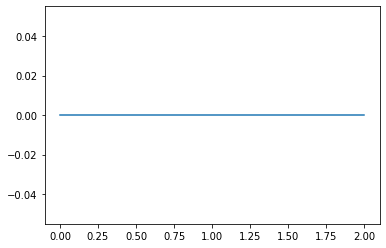

In [ ]:
plt.plot(mod_metrics_1.history['recall_Country_0'])
plt.show()

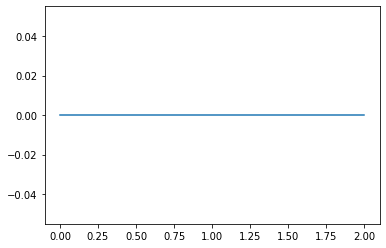

In [ ]:
plt.plot(mod_metrics_1.history['recall_Electronic_1'])
plt.show()

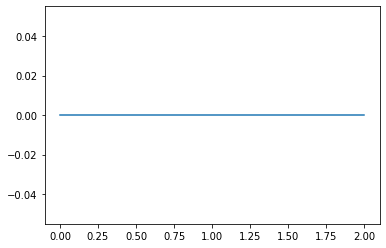

In [ ]:
plt.plot(mod_metrics_1.history['recall_Folk_2'])
plt.show()

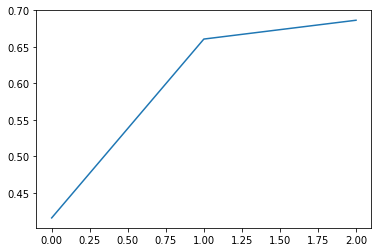

In [ ]:
plt.plot(mod_metrics_1.history['recall_Hip_Hop_3'])
plt.show()

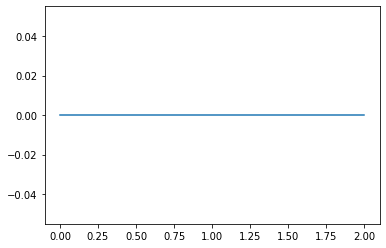

In [ ]:
plt.plot(mod_metrics_1.history['recall_Indie_4'])
plt.show()

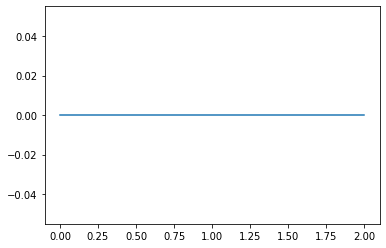

In [ ]:
plt.plot(mod_metrics_1.history['recall_Jazz_5'])
plt.show()

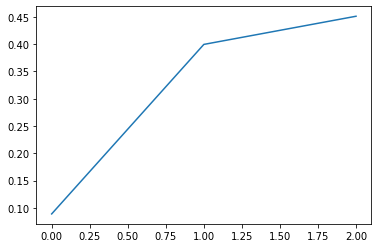

In [ ]:
plt.plot(mod_metrics_1.history['recall_Metal_6'])
plt.show()

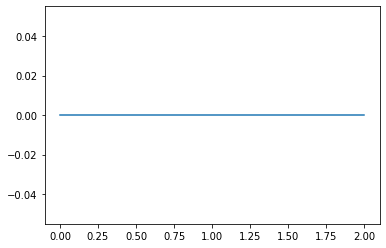

In [ ]:
plt.plot(mod_metrics_1.history['recall_Other_7'])
plt.show()

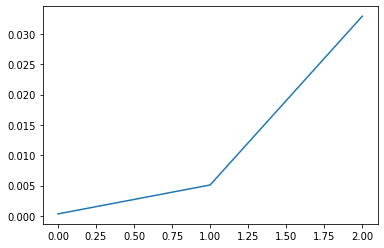

In [ ]:
plt.plot(mod_metrics_1.history['recall_Pop_8'])
plt.show()

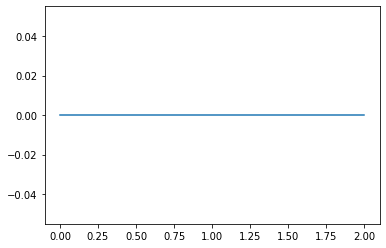

In [ ]:
plt.plot(mod_metrics_1.history['recall_RB_9'])
plt.show()

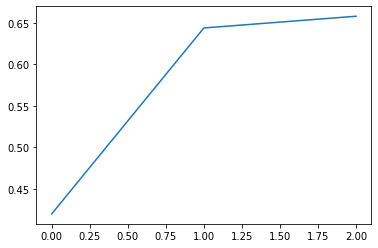

In [ ]:
plt.plot(mod_metrics_1.history['recall_Rock_10'])
plt.show()

In [ ]:
preds_app_1 = preds_1

In [ ]:
for i in range(preds_app_1.shape[0]):
  for j in range(preds_app_1.shape[1]):
    if max(preds_app_1[i,]) == preds_app_1[i,j]:
      preds_app_1[i,j] = 1
    else:
      preds_app_1[i,j] = 0

In [ ]:
preds_str_1 = np.zeros((3, preds_app_1.shape[0]))

for i in range(preds_app_1.shape[0]):
  for j in range(preds_app_1.shape[1]):
    if (y_test_small[i,j] == 1) & (preds_app_1[i,j] == 1):
      preds_str_1[0,i] = j
      preds_str_1[1,i] = j
      preds_str_1[2,i] = 1
    elif (y_test_small[i,j] == 0) & (preds_app_1[i,j] == 1):
      preds_str_1[1,i] = j
    elif (y_test_small[i,j] == 1) & (preds_app_1[i,j] == 0):
      preds_str_1[0,i] = j
    else :
      True

In [ ]:
preds_str_1

array([[10., 10., 10., ..., 10.,  3., 10.],
       [10., 10., 10., ..., 10.,  3., 10.],
       [ 1.,  1.,  1., ...,  1.,  1.,  1.]])

In [ ]:
genre_str

array(['Country', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Jazz',
       'Metal', 'Other', 'Pop', 'R&B', 'Rock'], dtype=object)

**Number of accurate predictions :**

In [ ]:
sum(sum(preds_str_1[[2]]))


2819.0

**Error Rate :**

In [ ]:
(preds_str_1.shape[1] - sum(sum(preds_str_1[[2]])))/preds_str_1.shape[1]


0.4362

The Bidirectionnal LSTM with GloVe Embedding gives us an error of 43,6 %. Which means that 52,4% of the predictions are correct.

##**3. Success prediction**

After comparing FastText and GloVe in order to predict genre, we will try to do the same but for success prediction with data_success.

We created 3 ways to measure the success of a record : its number of spotify streams, its deezer rate and its number of  youtube views.\
We will try tro predict each one of these indicators using FastText and GloVe.

###**3.1. Number of Spotify streams**

We start with the spotify streams, first dropping NAs in order to have a clean dataset.

In [ ]:
data = data_success
data.head()

,index,song,year,artist,genre,lyrics,spotify_streams,deezer_rate,youtube_views
0,248635,live-for-the-one-you-love,2008,celine-dion,Pop,A million stars light This beautiful night Thi...,1724337.0,"3,03",104000
1,117972,perfection,2006,bonnie-tyler,Pop,desmond child diane warren Producer for bonni...,NaN,NaN,18000
2,362048,watch-this,2006,clay-walker,Country,If you've never felt what happens When two hea...,751902.0,"1,45",301000
3,316112,stormy-ballad-of-a-vampire,2008,blind-iris,Rock,Stormy says the sun is too bright She sleeps i...,1000.0,"0,31",43
4,23395,the-revelation-embodied,2007,cult-of-luna,Rock,A time lost to the sick crowd of a new demonic...,117748.0,"0,86",2300


In [ ]:
data.shape

(100, 9)

In [ ]:
data.dropna(subset=['spotify_streams'], inplace=True)
data.shape

(80, 9)

In [ ]:
data = data.reset_index(drop=True)
data.head()

,index,song,year,artist,genre,lyrics,spotify_streams,deezer_rate,youtube_views
0,248635,live-for-the-one-you-love,2008,celine-dion,Pop,A million stars light This beautiful night Thi...,1724337.0,"3,03",104000
1,362048,watch-this,2006,clay-walker,Country,If you've never felt what happens When two hea...,751902.0,"1,45",301000
2,316112,stormy-ballad-of-a-vampire,2008,blind-iris,Rock,Stormy says the sun is too bright She sleeps i...,1000.0,"0,31",43
3,23395,the-revelation-embodied,2007,cult-of-luna,Rock,A time lost to the sick crowd of a new demonic...,117748.0,"0,86",2300
4,234977,orgasm-through-torture,2006,cannibal-corpse,Metal,Suffer to survive Instinct I despise Stalking ...,216642.0,"1,45",40 000


In [ ]:
data['spotify_streams']

0     1724337.0
1      751902.0
2        1000.0
3      117748.0
4      216642.0
        ...    
75     897058.0
76    4763207.0
77      39809.0
78    1036908.0
79     158508.0
Name: spotify_streams, Length: 80, dtype: float64

We create 6 classes for our variable spotify_streams :
- $< 10k$ streams
- $< 50k$ streams
- $< 250k$ streams
- $< 1000k$ streams
- $< 5000k$ streams
- $\geq 5000k$ streams

In [ ]:
for i in range(data.shape[0]):
  val = data['spotify_streams'][i]  
  if (val <= 10000):
    data['spotify_streams'][i] = '<10k'   
  elif (val <= 50000) & (val > 10000):
    data['spotify_streams'][i] = '<50k'    
  elif (val <= 250000) & (val > 50000):
    data['spotify_streams'][i] = '<250k'    
  elif (val <= 1000000) & (val > 250000):
    data['spotify_streams'][i] = '<1000k'    
  elif (val <= 5000000) & (val > 1000000):
    data['spotify_streams'][i] = '<5000k'    
  else:
    data['spotify_streams'][i] = '>5000k'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while w

In [ ]:
data.head()

,index,song,year,artist,genre,lyrics,spotify_streams,deezer_rate,youtube_views
0,248635,live-for-the-one-you-love,2008,celine-dion,Pop,A million stars light This beautiful night Thi...,<5000k,"3,03",104000
1,362048,watch-this,2006,clay-walker,Country,If you've never felt what happens When two hea...,<1000k,"1,45",301000
2,316112,stormy-ballad-of-a-vampire,2008,blind-iris,Rock,Stormy says the sun is too bright She sleeps i...,<10k,"0,31",43
3,23395,the-revelation-embodied,2007,cult-of-luna,Rock,A time lost to the sick crowd of a new demonic...,<250k,"0,86",2300
4,234977,orgasm-through-torture,2006,cannibal-corpse,Metal,Suffer to survive Instinct I despise Stalking ...,<250k,"1,45",40 000


In [ ]:
lyrics_data = data['lyrics'].values
max_words = 1000

# Create a new Tokenizer
tokenizer = text.Tokenizer(num_words=max_words, oov_token='<UNK>')
# Feed our song lyrics to the Tokenizer
tokenizer.fit_on_texts(lyrics_data)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)
    
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= max_words} # <= because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] = max_words + 1
indexed_data = tokenizer.texts_to_sequences(lyrics_data)
indexed_data = np.array(indexed_data)

label_encoder = skpp.LabelEncoder()
indexed_labels = np.array(label_encoder.fit_transform(data['spotify_streams'].values))


num_test = 20 #80 linesin total, 20 are kept for testing, 60 for training

# Shuffle data before splitting off test set
random_indexes = np.random.permutation(len(indexed_labels))
indexed_data = indexed_data[random_indexes]
indexed_labels = indexed_labels[random_indexes]

X_train = indexed_data[:-num_test]
y_train = indexed_labels[:-num_test]
X_test  = indexed_data[-num_test:]
y_test  = indexed_labels[-num_test:]

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

num_words = max_words + 2
# Truncate and pad input sequences
max_review_length = 500

X_train_padded = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_padded = sequence.pad_sequences(X_test, maxlen=max_review_length)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
spotify_str = label_encoder.inverse_transform(np.array([0,1,2,3,4,5]))
label_encoder.inverse_transform(np.array([0,1,2,3,4,5]))

array(['<1000k', '<10k', '<250k', '<5000k', '<50k', '>5000k'],
      dtype=object)

In [ ]:
y_train.shape

(60, 6)

In [ ]:
y_test.shape


(20, 6)

####**3.1.1 FastText Embedding**

We then start with the FastText Embedding.

In [ ]:
import codecs
from tqdm import tqdm
embeddings_index = {}
#f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8') #FastText trained on wikipedia 2017
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8') #FastText trained on common crawl
for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

1999996it [03:51, 8631.90it/s]


In [ ]:
word_index = tokenizer.word_index
MAX_NB_WORDS = 1000
embed_dim = 300

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
  if i >= nb_words:
     continue
  embedding_vector = embeddings_index.get(word)
  
  if (embedding_vector is not None) and len(embedding_vector) > 0:
     embedding_matrix[i] = embedding_vector
  else:
     words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 30


In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf
from keras.layers import Dropout


# Hyperparameters
embedding_vector_length = 50

# Create the Bidirectional LSTM model with Keras
model_2 = Sequential()
model_2.add(Embedding(num_words, embedding_vector_length, input_length=max_review_length))
model_2.add(Bidirectional(LSTM(60, return_sequences=True)))
model_2.add(GlobalMaxPooling1D())
model_2.add(Dense(6, activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 50)           50100     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 500, 120)          53280     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 120)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 726       
Total params: 104,106
Trainable params: 104,106
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
X_train_padded.shape

(60, 500)

In [ ]:
y_train.shape

(60, 6)

In [ ]:
model_2.fit(X_train_padded, y_train, batch_size=10, epochs=30)

Epoch 1/30
6/6 [==============================] - 5s 274ms/step - loss: 1.7935 - accuracy: 0.0638
Epoch 2/30
6/6 [==============================] - 2s 279ms/step - loss: 1.7719 - accuracy: 0.3555
Epoch 3/30
6/6 [==============================] - 2s 274ms/step - loss: 1.7486 - accuracy: 0.4769
Epoch 4/30
6/6 [==============================] - 2s 276ms/step - loss: 1.7333 - accuracy: 0.3843
Epoch 5/30
6/6 [==============================] - 2s 273ms/step - loss: 1.7167 - accuracy: 0.2557
Epoch 6/30
6/6 [==============================] - 2s 271ms/step - loss: 1.7141 - accuracy: 0.1955
Epoch 7/30
6/6 [==============================] - 2s 280ms/step - loss: 1.6601 - accuracy: 0.3071
Epoch 8/30
6/6 [==============================] - 2s 277ms/step - loss: 1.6535 - accuracy: 0.2136
Epoch 9/30
6/6 [==============================] - 2s 266ms/step - loss: 1.6193 - accuracy: 0.2933
Epoch 10/30
6/6 [==============================] - 2s 272ms/step - loss: 1.6113 - accuracy: 0.2221
Epoch 11/30
6/6 [==

In [ ]:
preds_2 = model_2.predict(X_test_padded, batch_size=10)

In [ ]:
preds_2

array([[0.06186399, 0.02992813, 0.45766273, 0.04241708, 0.33803105,
        0.07009694],
       [0.00168522, 0.6862308 , 0.00237399, 0.19924049, 0.09931628,
        0.01115326],
       [0.00134129, 0.37728685, 0.0105143 , 0.251393  , 0.32761288,
        0.03185168],
       [0.01758393, 0.00545485, 0.00154963, 0.913282  , 0.00722113,
        0.05490841],
       [0.04958387, 0.02823097, 0.43085885, 0.04540422, 0.36344457,
        0.08247754],
       [0.02490796, 0.66201437, 0.01645779, 0.02609634, 0.25723964,
        0.01328383],
       [0.0012431 , 0.56581223, 0.00554824, 0.2017159 , 0.20600027,
        0.01968024],
       [0.00148919, 0.35459337, 0.01291479, 0.21551135, 0.38004595,
        0.03544537],
       [0.7048564 , 0.00786003, 0.01979967, 0.1578172 , 0.02846503,
        0.08120164],
       [0.04671602, 0.02372014, 0.47591066, 0.04039123, 0.33635518,
        0.07690681],
       [0.03638524, 0.022972  , 0.3554631 , 0.07574104, 0.38741842,
        0.1220202 ],
       [0.09510576, 0

In [ ]:
preds_app_2 = preds_2

In [ ]:
for i in range(preds_app_2.shape[0]):
  for j in range(preds_app_2.shape[1]):
    if max(preds_app_2[i,]) == preds_app_2[i,j]:
      preds_app_2[i,j] = 1
    else:
      preds_app_2[i,j] = 0

In [ ]:
preds_app_2.shape
y_test

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [ ]:
preds_str_2 = np.zeros((3, preds_app_2.shape[0]))

for i in range(preds_app_2.shape[0]):
  for j in range(preds_app_2.shape[1]):
    if (y_test[i,j] == 1) & (preds_app_2[i,j] == 1):
      preds_str_2[0,i] = j
      preds_str_2[1,i] = j
      preds_str_2[2,i] = 1
    elif (y_test[i,j] == 0) & (preds_app_2[i,j] == 1):
      preds_str_2[1,i] = j
    elif (y_test[i,j] == 1) & (preds_app_2[i,j] == 0):
      preds_str_2[0,i] = j
    else :
      True

In [ ]:
preds_str_2

array([[2., 5., 5., 0., 1., 3., 1., 4., 4., 4., 2., 3., 2., 4., 4., 4.,
        0., 3., 3., 0.],
       [2., 1., 1., 3., 2., 1., 1., 4., 0., 2., 4., 2., 3., 0., 4., 1.,
        0., 2., 3., 0.],
       [1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
        1., 0., 1., 1.]])

In [ ]:
spotify_str

array(['<1000k', '<10k', '<250k', '<5000k', '<50k', '>5000k'],
      dtype=object)

**Number of accurate predictions :**

In [ ]:
sum(sum(preds_str_2[[2]]))


7.0

**Error Rate :**

In [ ]:
(preds_str_2.shape[1] - sum(sum(preds_str_2[[2]])))/preds_str_2.shape[1]


0.65

The Bidirectionnal LSTM with FastText Embedding gives us an error of 65 % on success prediction measured with spotify streams. Which means that 35% of the predictions are correct.

####**3.1.2. GloVe Embedding**

Now for GloVe embedding.

In [ ]:
import codecs
from tqdm import tqdm
embeddings_index = {}
f = codecs.open('glove.840B.300d.txt', encoding='utf-8') #GloVe trained on common crawl
for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

2196018it [04:51, 7546.40it/s]


In [ ]:
word_index = tokenizer.word_index
MAX_NB_WORDS = 1000
embed_dim = 300

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
  if i >= nb_words:
     continue
  embedding_vector = embeddings_index.get(word)
  
  if (embedding_vector is not None) and len(embedding_vector) > 0:
     embedding_matrix[i] = embedding_vector
  else:
     words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 35


In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf
from keras.layers import Dropout


# Hyperparameters
embedding_vector_length = 50

# Create the Bidirectional LSTM model with Keras
model_3 = Sequential()
model_3.add(Embedding(num_words, embedding_vector_length, input_length=max_review_length))
model_3.add(Bidirectional(LSTM(60, return_sequences=True)))
model_3.add(GlobalMaxPooling1D())
model_3.add(Dense(6, activation='softmax'))
model_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 50)           50100     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 500, 120)          53280     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 726       
Total params: 104,106
Trainable params: 104,106
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_3.fit(X_train_padded, y_train, batch_size=10, epochs=30)

Epoch 1/30
6/6 [==============================] - 5s 277ms/step - loss: 1.7962 - accuracy: 0.2138
Epoch 2/30
6/6 [==============================] - 2s 273ms/step - loss: 1.7698 - accuracy: 0.2952
Epoch 3/30
6/6 [==============================] - 2s 267ms/step - loss: 1.7511 - accuracy: 0.2300
Epoch 4/30
6/6 [==============================] - 2s 267ms/step - loss: 1.7443 - accuracy: 0.1940
Epoch 5/30
6/6 [==============================] - 2s 266ms/step - loss: 1.7490 - accuracy: 0.1862
Epoch 6/30
6/6 [==============================] - 2s 262ms/step - loss: 1.7355 - accuracy: 0.1357
Epoch 7/30
6/6 [==============================] - 2s 274ms/step - loss: 1.7155 - accuracy: 0.1700
Epoch 8/30
6/6 [==============================] - 2s 269ms/step - loss: 1.6710 - accuracy: 0.2336
Epoch 9/30
6/6 [==============================] - 2s 268ms/step - loss: 1.6278 - accuracy: 0.2888
Epoch 10/30
6/6 [==============================] - 2s 269ms/step - loss: 1.6801 - accuracy: 0.2355
Epoch 11/30
6/6 [==

In [ ]:
preds_3 = model_3.predict(X_test_padded, batch_size=10)

In [ ]:
preds_app_3 = preds_3

In [ ]:
for i in range(preds_app_3.shape[0]):
  for j in range(preds_app_3.shape[1]):
    if max(preds_app_3[i,]) == preds_app_3[i,j]:
      preds_app_3[i,j] = 1
    else:
      preds_app_3[i,j] = 0

In [ ]:
preds_str_3 = np.zeros((3, preds_app_3.shape[0]))

for i in range(preds_app_3.shape[0]):
  for j in range(preds_app_3.shape[1]):
    if (y_test[i,j] == 1) & (preds_app_3[i,j] == 1):
      preds_str_3[0,i] = j
      preds_str_3[1,i] = j
      preds_str_3[2,i] = 1
    elif (y_test[i,j] == 0) & (preds_app_3[i,j] == 1):
      preds_str_3[1,i] = j
    elif (y_test[i,j] == 1) & (preds_app_3[i,j] == 0):
      preds_str_3[0,i] = j
    else :
      True

In [ ]:
preds_str_3

array([[2., 5., 5., 0., 1., 3., 1., 4., 4., 4., 2., 3., 2., 4., 4., 4.,
        0., 3., 3., 0.],
       [1., 1., 2., 3., 3., 2., 1., 2., 3., 1., 3., 2., 3., 3., 3., 1.,
        2., 2., 2., 2.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [ ]:
spotify_str

array(['<1000k', '<10k', '<250k', '<5000k', '<50k', '>5000k'],
      dtype=object)

**Number of accurate predictions :**

In [ ]:
sum(sum(preds_str_3[[2]]))


1.0

**Error Rate :**

In [ ]:
(preds_str_3.shape[1] - sum(sum(preds_str_3[[2]])))/preds_str_3.shape[1]


0.95

The Bidirectionnal LSTM with GloVe Embedding gives us an error of 95 % on success prediction measured with spotify streams. Which means that 5% of the predictions are correct.

###**3.2. Deezer rates**

We realize the same analysis for the success predictions measured with deezer rate.

In [ ]:
path = '100songs_rempli_final.csv'
data_success = pd.read_csv(path, sep= ';', skip_blank_lines=False)
data = data_success
data.head()

,index,song,year,artist,genre,lyrics,spotify_streams,deezer_rate,youtube_views
0,248635,live-for-the-one-you-love,2008,celine-dion,Pop,A million stars light This beautiful night Thi...,1724337.0,"3,03",104000
1,117972,perfection,2006,bonnie-tyler,Pop,desmond child diane warren Producer for bonni...,NaN,NaN,18000
2,362048,watch-this,2006,clay-walker,Country,If you've never felt what happens When two hea...,751902.0,"1,45",301000
3,316112,stormy-ballad-of-a-vampire,2008,blind-iris,Rock,Stormy says the sun is too bright She sleeps i...,1000.0,"0,31",43
4,23395,the-revelation-embodied,2007,cult-of-luna,Rock,A time lost to the sick crowd of a new demonic...,117748.0,"0,86",2300


In [ ]:
data.shape

(100, 9)

In [ ]:
data.dropna(subset=['deezer_rate'], inplace=True)
data.shape

(76, 9)

In [ ]:
data = data.reset_index(drop=True)
data.head()

,index,song,year,artist,genre,lyrics,spotify_streams,deezer_rate,youtube_views
0,248635,live-for-the-one-you-love,2008,celine-dion,Pop,A million stars light This beautiful night Thi...,1724337.0,"3,03",104000
1,362048,watch-this,2006,clay-walker,Country,If you've never felt what happens When two hea...,751902.0,"1,45",301000
2,316112,stormy-ballad-of-a-vampire,2008,blind-iris,Rock,Stormy says the sun is too bright She sleeps i...,1000.0,"0,31",43
3,23395,the-revelation-embodied,2007,cult-of-luna,Rock,A time lost to the sick crowd of a new demonic...,117748.0,"0,86",2300
4,234977,orgasm-through-torture,2006,cannibal-corpse,Metal,Suffer to survive Instinct I despise Stalking ...,216642.0,"1,45",40 000


In [ ]:
data['deezer_rate'] = data['deezer_rate'].str.replace(',','.')

In [ ]:
data.head()

,index,song,year,artist,genre,lyrics,spotify_streams,deezer_rate,youtube_views
0,248635,live-for-the-one-you-love,2008,celine-dion,Pop,A million stars light This beautiful night Thi...,1724337.0,3.03,104000
1,362048,watch-this,2006,clay-walker,Country,If you've never felt what happens When two hea...,751902.0,1.45,301000
2,316112,stormy-ballad-of-a-vampire,2008,blind-iris,Rock,Stormy says the sun is too bright She sleeps i...,1000.0,0.31,43
3,23395,the-revelation-embodied,2007,cult-of-luna,Rock,A time lost to the sick crowd of a new demonic...,117748.0,0.86,2300
4,234977,orgasm-through-torture,2006,cannibal-corpse,Metal,Suffer to survive Instinct I despise Stalking ...,216642.0,1.45,40 000


We create 6 classes for our variable deezer_rate :
- rate $< 1$
- rate $< 2$
- rate $< 3$
- rate $< 4$
- rate $< 5$
- rate $\geq 5$

In [ ]:
for i in range(data.shape[0]):
  val = data['deezer_rate'][i]  
  val = float(val)
  if (val <= 1):
    data['deezer_rate'][i] = '<1'   
  elif (val <= 2) & (val > 1):
    data['deezer_rate'][i] = '<2'    
  elif (val <= 3) & (val > 2):
    data['deezer_rate'][i] = '<3'    
  elif (val <= 4) & (val > 3):
    data['deezer_rate'][i] = '<4'    
  elif (val <= 5) & (val > 4):
    data['deezer_rate'][i] = '<5'    
  else:
    data['deezer_rate'][i] = '>6'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-package

In [ ]:
data.head()

,index,song,year,artist,genre,lyrics,spotify_streams,deezer_rate,youtube_views
0,248635,live-for-the-one-you-love,2008,celine-dion,Pop,A million stars light This beautiful night Thi...,1724337.0,<4,104000
1,362048,watch-this,2006,clay-walker,Country,If you've never felt what happens When two hea...,751902.0,<2,301000
2,316112,stormy-ballad-of-a-vampire,2008,blind-iris,Rock,Stormy says the sun is too bright She sleeps i...,1000.0,<1,43
3,23395,the-revelation-embodied,2007,cult-of-luna,Rock,A time lost to the sick crowd of a new demonic...,117748.0,<1,2300
4,234977,orgasm-through-torture,2006,cannibal-corpse,Metal,Suffer to survive Instinct I despise Stalking ...,216642.0,<2,40 000


In [ ]:
lyrics_data = data['lyrics'].values
max_words = 1000

# Create a new Tokenizer
tokenizer = text.Tokenizer(num_words=max_words, oov_token='<UNK>')
# Feed our song lyrics to the Tokenizer
tokenizer.fit_on_texts(lyrics_data)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)
    
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= max_words} # <= because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] = max_words + 1
indexed_data = tokenizer.texts_to_sequences(lyrics_data)
indexed_data = np.array(indexed_data)

label_encoder = skpp.LabelEncoder()
indexed_labels = np.array(label_encoder.fit_transform(data['deezer_rate'].values))


num_test = 25 #76 linesin total, 25 are kept for testing, 51 for training

# Shuffle data before splitting off test set
random_indexes = np.random.permutation(len(indexed_labels))
indexed_data = indexed_data[random_indexes]
indexed_labels = indexed_labels[random_indexes]

X_train = indexed_data[:-num_test]
y_train = indexed_labels[:-num_test]
X_test  = indexed_data[-num_test:]
y_test  = indexed_labels[-num_test:]

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

num_words = max_words + 2
# Truncate and pad input sequences
max_review_length = 500

X_train_padded = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_padded = sequence.pad_sequences(X_test, maxlen=max_review_length)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
deezer_str = label_encoder.inverse_transform(np.array([0,1,2,3,4,5]))
label_encoder.inverse_transform(np.array([0,1,2,3,4,5]))

array(['<1', '<2', '<3', '<4', '<5', '>6'], dtype=object)

In [ ]:
y_train.shape

(51, 6)

In [ ]:
y_test.shape


(25, 6)

####**3.2.1. FastText Embedding**

We then start with the FastText Embedding.

In [ ]:
import codecs
from tqdm import tqdm
embeddings_index = {}
#f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8') #FastText trained on wikipedia 2017
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8') #FastText trained on common crawl
for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

1999996it [03:45, 8887.07it/s]


In [ ]:
word_index = tokenizer.word_index
MAX_NB_WORDS = 1000
embed_dim = 300

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
  if i >= nb_words:
     continue
  embedding_vector = embeddings_index.get(word)
  
  if (embedding_vector is not None) and len(embedding_vector) > 0:
     embedding_matrix[i] = embedding_vector
  else:
     words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 33


In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf
from keras.layers import Dropout


# Hyperparameters
embedding_vector_length = 50

# Create the Bidirectional LSTM model with Keras
model_4 = Sequential()
model_4.add(Embedding(num_words, embedding_vector_length, input_length=max_review_length))
model_4.add(Bidirectional(LSTM(60, return_sequences=True)))
model_4.add(GlobalMaxPooling1D())
model_4.add(Dense(6, activation='softmax'))
model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_4.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 50)           50100     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 500, 120)          53280     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 120)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 726       
Total params: 104,106
Trainable params: 104,106
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
X_train_padded.shape

(51, 500)

In [ ]:
y_train.shape

(51, 6)

In [ ]:
model_4.fit(X_train_padded, y_train, batch_size=10, epochs=30)

Epoch 1/30
6/6 [==============================] - 7s 334ms/step - loss: 1.7854 - accuracy: 0.1561
Epoch 2/30
6/6 [==============================] - 2s 335ms/step - loss: 1.7010 - accuracy: 0.5172
Epoch 3/30
6/6 [==============================] - 2s 330ms/step - loss: 1.5880 - accuracy: 0.4890
Epoch 4/30
6/6 [==============================] - 2s 328ms/step - loss: 1.3660 - accuracy: 0.5195
Epoch 5/30
6/6 [==============================] - 3s 431ms/step - loss: 1.2823 - accuracy: 0.5128
Epoch 6/30
6/6 [==============================] - 3s 520ms/step - loss: 1.2106 - accuracy: 0.5318
Epoch 7/30
6/6 [==============================] - 3s 413ms/step - loss: 1.2263 - accuracy: 0.5232
Epoch 8/30
6/6 [==============================] - 2s 327ms/step - loss: 1.2503 - accuracy: 0.5792
Epoch 9/30
6/6 [==============================] - 2s 335ms/step - loss: 1.3773 - accuracy: 0.4845
Epoch 10/30
6/6 [==============================] - 2s 336ms/step - loss: 1.1288 - accuracy: 0.5940
Epoch 11/30
6/6 [==

In [ ]:
preds_4 = model_4.predict(X_test_padded, batch_size=10)

In [ ]:
preds_4

array([[0.70538765, 0.13672033, 0.08856846, 0.02714371, 0.02930493,
        0.01287501],
       [0.81606936, 0.06838793, 0.04941763, 0.03481695, 0.01844391,
        0.0128642 ],
       [0.8613256 , 0.05157271, 0.03985428, 0.02211677, 0.01533037,
        0.00980034],
       [0.76302004, 0.08775935, 0.0602783 , 0.05114028, 0.02151094,
        0.01629113],
       [0.7998534 , 0.08197015, 0.05379718, 0.03278468, 0.01852385,
        0.01307076],
       [0.8278081 , 0.07007576, 0.04892381, 0.02518461, 0.01672367,
        0.01128404],
       [0.83607864, 0.06197612, 0.04668717, 0.02693281, 0.01666556,
        0.01165973],
       [0.48369125, 0.23645961, 0.11185467, 0.11267778, 0.02571285,
        0.02960386],
       [0.8374602 , 0.06072188, 0.04658644, 0.02684225, 0.01679412,
        0.01159508],
       [0.8271346 , 0.0638627 , 0.0494858 , 0.02953891, 0.0178735 ,
        0.01210451],
       [0.8499361 , 0.05562024, 0.04320759, 0.02455362, 0.01632097,
        0.0103613 ],
       [0.8285984 , 0

In [ ]:
preds_app_4 = preds_4

In [ ]:
for i in range(preds_app_4.shape[0]):
  for j in range(preds_app_4.shape[1]):
    if max(preds_app_4[i,]) == preds_app_4[i,j]:
      preds_app_4[i,j] = 1
    else:
      preds_app_4[i,j] = 0

In [ ]:
preds_app_4.shape
y_test.shape

(25, 6)

In [ ]:
preds_str_4 = np.zeros((3, preds_app_4.shape[0]))

for i in range(preds_app_4.shape[0]):
  for j in range(preds_app_4.shape[1]):
    if (y_test[i,j] == 1) & (preds_app_4[i,j] == 1):
      preds_str_4[0,i] = j
      preds_str_4[1,i] = j
      preds_str_4[2,i] = 1
    elif (y_test[i,j] == 0) & (preds_app_4[i,j] == 1):
      preds_str_4[1,i] = j
    elif (y_test[i,j] == 1) & (preds_app_4[i,j] == 0):
      preds_str_4[0,i] = j
    else :
      True

In [ ]:
preds_str_4

array([[5., 0., 0., 1., 1., 1., 1., 0., 1., 4., 0., 3., 0., 3., 1., 0.,
        0., 1., 0., 0., 3., 1., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1.,
        1., 0., 1., 1., 0., 0., 1., 1., 0.]])

In [ ]:
deezer_str

array(['<1', '<2', '<3', '<4', '<5', '>6'], dtype=object)

**Number of accurate predictions :**

In [ ]:
sum(sum(preds_str_4[[2]]))


11.0

**Error Rate :**

In [ ]:
(preds_str_4.shape[1] - sum(sum(preds_str_4[[2]])))/preds_str_4.shape[1]

0.56

The Bidirectionnal LSTM with FastText Embedding gives us an error of 56 % on success prediction measured with the Deezer Rate. Which means that 44% of the predictions are correct.

####**3.2.2. GloVe Embedding**

Now for GloVe embedding

In [ ]:
import codecs
from tqdm import tqdm
embeddings_index = {}
f = codecs.open('glove.840B.300d.txt', encoding='utf-8') #GloVe trained on common crawl
for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

2196018it [04:42, 7780.93it/s]


In [ ]:
word_index = tokenizer.word_index
MAX_NB_WORDS = 1000
embed_dim = 300

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
  if i >= nb_words:
     continue
  embedding_vector = embeddings_index.get(word)
  
  if (embedding_vector is not None) and len(embedding_vector) > 0:
     embedding_matrix[i] = embedding_vector
  else:
     words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 38


In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf
from keras.layers import Dropout


# Hyperparameters
embedding_vector_length = 50

# Create the Bidirectional LSTM model with Keras
model_5 = Sequential()
model_5.add(Embedding(num_words, embedding_vector_length, input_length=max_review_length))
model_5.add(Bidirectional(LSTM(60, return_sequences=True)))
model_5.add(GlobalMaxPooling1D())
model_5.add(Dense(6, activation='softmax'))
model_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_5.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 50)           50100     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 500, 120)          53280     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 120)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 726       
Total params: 104,106
Trainable params: 104,106
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_5.fit(X_train_padded, y_train, batch_size=10, epochs=30)

Epoch 1/30
6/6 [==============================] - 6s 331ms/step - loss: 1.7852 - accuracy: 0.1912
Epoch 2/30
6/6 [==============================] - 2s 328ms/step - loss: 1.7015 - accuracy: 0.5290
Epoch 3/30
6/6 [==============================] - 2s 336ms/step - loss: 1.5927 - accuracy: 0.5373
Epoch 4/30
6/6 [==============================] - 2s 334ms/step - loss: 1.3931 - accuracy: 0.5159
Epoch 5/30
6/6 [==============================] - 2s 330ms/step - loss: 1.4522 - accuracy: 0.4509
Epoch 6/30
6/6 [==============================] - 2s 330ms/step - loss: 1.2748 - accuracy: 0.5576
Epoch 7/30
6/6 [==============================] - 2s 331ms/step - loss: 1.3104 - accuracy: 0.4926
Epoch 8/30
6/6 [==============================] - 2s 342ms/step - loss: 1.2930 - accuracy: 0.4611
Epoch 9/30
6/6 [==============================] - 2s 341ms/step - loss: 1.3471 - accuracy: 0.4349
Epoch 10/30
6/6 [==============================] - 2s 338ms/step - loss: 1.1636 - accuracy: 0.5457
Epoch 11/30
6/6 [==

In [ ]:
preds_5 = model_5.predict(X_test_padded, batch_size=10)

In [ ]:
preds_app_5 = preds_5

In [ ]:
for i in range(preds_app_5.shape[0]):
  for j in range(preds_app_5.shape[1]):
    if max(preds_app_5[i,]) == preds_app_5[i,j]:
      preds_app_5[i,j] = 1
    else:
      preds_app_5[i,j] = 0

In [ ]:
preds_str_5 = np.zeros((3, preds_app_5.shape[0]))

for i in range(preds_app_5.shape[0]):
  for j in range(preds_app_5.shape[1]):
    if (y_test[i,j] == 1) & (preds_app_5[i,j] == 1):
      preds_str_5[0,i] = j
      preds_str_5[1,i] = j
      preds_str_5[2,i] = 1
    elif (y_test[i,j] == 0) & (preds_app_5[i,j] == 1):
      preds_str_5[1,i] = j
    elif (y_test[i,j] == 1) & (preds_app_5[i,j] == 0):
      preds_str_5[0,i] = j
    else :
      True

In [ ]:
preds_str_5

array([[5., 0., 0., 1., 1., 1., 1., 0., 1., 4., 0., 3., 0., 3., 1., 0.,
        0., 1., 0., 0., 3., 1., 0., 0., 1.],
       [1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 0., 0., 1., 0., 1., 1., 1., 0.],
       [0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 1., 0., 0., 1., 0., 0., 0.]])

In [ ]:
deezer_str

array(['<1', '<2', '<3', '<4', '<5', '>6'], dtype=object)

**Number of accurate predictions :**

In [ ]:
sum(sum(preds_str_5[[2]]))


9.0

**Error Rate :**

In [ ]:
(preds_str_5.shape[1] - sum(sum(preds_str_5[[2]])))/preds_str_5.shape[1]


0.64

The Bidirectionnal LSTM with GloVe Embedding gives us an error of 64 % on success prediction measured with the Deezer Rate. Which means that 36% of the predictions are correct.

###**3.3. Number of Youtube views**

We realize the same analysis for the success predictions measured with YouTube number of views.

In [ ]:
path = '100songs_rempli_final.csv'
data_success = pd.read_csv(path, sep= ';', skip_blank_lines=False)
data = data_success
data.head()

,index,song,year,artist,genre,lyrics,spotify_streams,deezer_rate,youtube_views
0,248635,live-for-the-one-you-love,2008,celine-dion,Pop,A million stars light This beautiful night Thi...,1724337.0,"3,03",104000
1,117972,perfection,2006,bonnie-tyler,Pop,desmond child diane warren Producer for bonni...,NaN,NaN,18000
2,362048,watch-this,2006,clay-walker,Country,If you've never felt what happens When two hea...,751902.0,"1,45",301000
3,316112,stormy-ballad-of-a-vampire,2008,blind-iris,Rock,Stormy says the sun is too bright She sleeps i...,1000.0,"0,31",43
4,23395,the-revelation-embodied,2007,cult-of-luna,Rock,A time lost to the sick crowd of a new demonic...,117748.0,"0,86",2300


In [ ]:
data.shape

(100, 9)

In [ ]:
data.dropna(subset=['youtube_views'], inplace=True)
data.shape

(91, 9)

In [ ]:
data = data.reset_index(drop=True)
data.head()

,index,song,year,artist,genre,lyrics,spotify_streams,deezer_rate,youtube_views
0,248635,live-for-the-one-you-love,2008,celine-dion,Pop,A million stars light This beautiful night Thi...,1724337.0,"3,03",104000
1,117972,perfection,2006,bonnie-tyler,Pop,desmond child diane warren Producer for bonni...,NaN,NaN,18000
2,362048,watch-this,2006,clay-walker,Country,If you've never felt what happens When two hea...,751902.0,"1,45",301000
3,316112,stormy-ballad-of-a-vampire,2008,blind-iris,Rock,Stormy says the sun is too bright She sleeps i...,1000.0,"0,31",43
4,23395,the-revelation-embodied,2007,cult-of-luna,Rock,A time lost to the sick crowd of a new demonic...,117748.0,"0,86",2300


In [ ]:
data['youtube_views'] = data['youtube_views'].str.replace(' ','')
data.head()

,index,song,year,artist,genre,lyrics,spotify_streams,deezer_rate,youtube_views
0,248635,live-for-the-one-you-love,2008,celine-dion,Pop,A million stars light This beautiful night Thi...,1724337.0,"3,03",104000
1,117972,perfection,2006,bonnie-tyler,Pop,desmond child diane warren Producer for bonni...,NaN,NaN,18000
2,362048,watch-this,2006,clay-walker,Country,If you've never felt what happens When two hea...,751902.0,"1,45",301000
3,316112,stormy-ballad-of-a-vampire,2008,blind-iris,Rock,Stormy says the sun is too bright She sleeps i...,1000.0,"0,31",43
4,23395,the-revelation-embodied,2007,cult-of-luna,Rock,A time lost to the sick crowd of a new demonic...,117748.0,"0,86",2300


We create 6 classes for our variable youtube_views :
- $\leq 10k$ views
- $\leq 50k$ views
- $\leq 100k$ views
- $\leq 500k$ views
- $\leq 1000k$ views
- $> 1000k$ views

In [ ]:
for i in range(data.shape[0]):
  val = data['youtube_views'][i]  
  val = float(val)
  if (val <= 10000):
    data['youtube_views'][i] = '<10k'   
  elif (val <= 50000) & (val > 10000):
    data['youtube_views'][i] = '<50k'    
  elif (val <= 100000) & (val > 50000):
    data['youtube_views'][i] = '<100k'    
  elif (val <= 500000) & (val > 100000):
    data['youtube_views'][i] = '<500k'    
  elif (val <= 1000000) & (val > 500000):
    data['youtube_views'][i] = '<1000k'    
  else:
    data['youtube_views'][i] = '>1000k'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-package

In [ ]:
data.head()

,index,song,year,artist,genre,lyrics,spotify_streams,deezer_rate,youtube_views
0,248635,live-for-the-one-you-love,2008,celine-dion,Pop,A million stars light This beautiful night Thi...,1724337.0,"3,03",<500k
1,117972,perfection,2006,bonnie-tyler,Pop,desmond child diane warren Producer for bonni...,NaN,NaN,<50k
2,362048,watch-this,2006,clay-walker,Country,If you've never felt what happens When two hea...,751902.0,"1,45",<500k
3,316112,stormy-ballad-of-a-vampire,2008,blind-iris,Rock,Stormy says the sun is too bright She sleeps i...,1000.0,"0,31",<10k
4,23395,the-revelation-embodied,2007,cult-of-luna,Rock,A time lost to the sick crowd of a new demonic...,117748.0,"0,86",<10k


In [ ]:
lyrics_data = data['lyrics'].values
max_words = 1000

# Create a new Tokenizer
tokenizer = text.Tokenizer(num_words=max_words, oov_token='<UNK>')
# Feed our song lyrics to the Tokenizer
tokenizer.fit_on_texts(lyrics_data)

# Tokenizers come with a convenient list of words and IDs
dictionary = tokenizer.word_index

with open('dictionary.json', 'w') as dictionary_file:
    json.dump(dictionary, dictionary_file)
    
tokenizer.word_index = {e:i for e,i in tokenizer.word_index.items() if i <= max_words} # <= because tokenizer is 1 indexed
tokenizer.word_index[tokenizer.oov_token] = max_words + 1
indexed_data = tokenizer.texts_to_sequences(lyrics_data)
indexed_data = np.array(indexed_data)

label_encoder = skpp.LabelEncoder()
indexed_labels = np.array(label_encoder.fit_transform(data['youtube_views'].values))


num_test = 25 #91 linesin total, 25 are kept for testing, 66 for training

# Shuffle data before splitting off test set
random_indexes = np.random.permutation(len(indexed_labels))
indexed_data = indexed_data[random_indexes]
indexed_labels = indexed_labels[random_indexes]

X_train = indexed_data[:-num_test]
y_train = indexed_labels[:-num_test]
X_test  = indexed_data[-num_test:]
y_test  = indexed_labels[-num_test:]

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

num_words = max_words + 2
# Truncate and pad input sequences
max_review_length = 500

X_train_padded = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test_padded = sequence.pad_sequences(X_test, maxlen=max_review_length)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
youtube_str = label_encoder.inverse_transform(np.array([0,1,2,3,4,5]))
label_encoder.inverse_transform(np.array([0,1,2,3,4,5]))

array(['<1000k', '<100k', '<10k', '<500k', '<50k', '>1000k'], dtype=object)

In [ ]:
y_train.shape

(66, 6)

In [ ]:
y_test.shape


(25, 6)

####**3.2.1. FastText Embedding**

We then start with the FastText Embedding.

In [ ]:
import codecs
from tqdm import tqdm
embeddings_index = {}
#f = codecs.open('wiki-news-300d-1M.vec', encoding='utf-8') #FastText trained on wikipedia 2017
f = codecs.open('crawl-300d-2M.vec', encoding='utf-8') #FastText trained on common crawl
for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

1999996it [03:45, 8887.28it/s]


In [ ]:
word_index = tokenizer.word_index
MAX_NB_WORDS = 1000
embed_dim = 300

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
  if i >= nb_words:
     continue
  embedding_vector = embeddings_index.get(word)
  
  if (embedding_vector is not None) and len(embedding_vector) > 0:
     embedding_matrix[i] = embedding_vector
  else:
     words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 36


In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf
from keras.layers import Dropout


# Hyperparameters
embedding_vector_length = 50

# Create the Bidirectional LSTM model with Keras
model_6 = Sequential()
model_6.add(Embedding(num_words, embedding_vector_length, input_length=max_review_length))
model_6.add(Bidirectional(LSTM(60, return_sequences=True)))
model_6.add(GlobalMaxPooling1D())
model_6.add(Dense(6, activation='softmax'))
model_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_6.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 50)           50100     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 500, 120)          53280     
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 120)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 726       
Total params: 104,106
Trainable params: 104,106
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
X_train_padded.shape

(66, 500)

In [ ]:
y_train.shape

(66, 6)

In [ ]:
model_6.fit(X_train_padded, y_train, batch_size=10, epochs=30)

Epoch 1/30
7/7 [==============================] - 7s 349ms/step - loss: 1.7875 - accuracy: 0.1490
Epoch 2/30
7/7 [==============================] - 2s 338ms/step - loss: 1.7347 - accuracy: 0.2785
Epoch 3/30
7/7 [==============================] - 2s 346ms/step - loss: 1.6742 - accuracy: 0.2920
Epoch 4/30
7/7 [==============================] - 2s 343ms/step - loss: 1.6204 - accuracy: 0.2687
Epoch 5/30
7/7 [==============================] - 2s 344ms/step - loss: 1.5523 - accuracy: 0.3089
Epoch 6/30
7/7 [==============================] - 2s 340ms/step - loss: 1.5794 - accuracy: 0.2420
Epoch 7/30
7/7 [==============================] - 2s 351ms/step - loss: 1.5850 - accuracy: 0.3108
Epoch 8/30
7/7 [==============================] - 2s 341ms/step - loss: 1.5413 - accuracy: 0.2801
Epoch 9/30
7/7 [==============================] - 2s 345ms/step - loss: 1.5318 - accuracy: 0.4164
Epoch 10/30
7/7 [==============================] - 2s 336ms/step - loss: 1.4112 - accuracy: 0.5559
Epoch 11/30
7/7 [==

In [ ]:
preds_6 = model_6.predict(X_test_padded, batch_size=10)

In [ ]:
preds_6

array([[1.75021857e-01, 2.54840683e-03, 3.92881706e-02, 1.04348779e-01,
        6.26676142e-01, 5.21165766e-02],
       [1.56201329e-02, 4.24633035e-04, 9.10116076e-01, 1.58027431e-03,
        6.40837029e-02, 8.17515515e-03],
       [1.52409911e-01, 1.75668485e-03, 3.33169997e-02, 5.89498393e-02,
        7.11028755e-01, 4.25377637e-02],
       [5.65589890e-02, 3.15458365e-02, 4.64215949e-02, 5.14877379e-01,
        3.86023452e-03, 3.46735954e-01],
       [2.78288871e-01, 3.38703487e-03, 7.97027573e-02, 2.96426229e-02,
        8.60727206e-02, 5.22906005e-01],
       [1.17134176e-01, 1.63517299e-03, 3.44302952e-02, 3.40767093e-02,
        7.85450339e-01, 2.72733606e-02],
       [2.61327654e-01, 2.63211457e-03, 3.23219523e-02, 2.11845376e-02,
        6.37124330e-02, 6.18821323e-01],
       [1.48130730e-02, 4.86448960e-04, 9.19992328e-01, 1.73095590e-03,
        5.42302355e-02, 8.74699745e-03],
       [1.97861046e-01, 2.14016298e-03, 3.13812979e-02, 9.45968851e-02,
        6.20001495e-01, 

In [ ]:
preds_app_6 = preds_6

In [ ]:
for i in range(preds_app_6.shape[0]):
  for j in range(preds_app_6.shape[1]):
    if max(preds_app_6[i,]) == preds_app_6[i,j]:
      preds_app_6[i,j] = 1
    else:
      preds_app_6[i,j] = 0

In [ ]:
preds_app_6.shape
y_test.shape

(25, 6)

In [ ]:
preds_str_6 = np.zeros((3, preds_app_6.shape[0]))

for i in range(preds_app_6.shape[0]):
  for j in range(preds_app_6.shape[1]):
    if (y_test[i,j] == 1) & (preds_app_6[i,j] == 1):
      preds_str_6[0,i] = j
      preds_str_6[1,i] = j
      preds_str_6[2,i] = 1
    elif (y_test[i,j] == 0) & (preds_app_6[i,j] == 1):
      preds_str_6[1,i] = j
    elif (y_test[i,j] == 1) & (preds_app_6[i,j] == 0):
      preds_str_6[0,i] = j
    else :
      True

In [ ]:
preds_str_6

array([[2., 2., 2., 2., 1., 4., 1., 2., 0., 3., 4., 3., 3., 3., 0., 2.,
        4., 4., 5., 3., 4., 3., 4., 3., 5.],
       [4., 2., 4., 3., 5., 4., 5., 2., 4., 4., 5., 4., 2., 2., 3., 4.,
        5., 3., 5., 4., 5., 2., 4., 4., 3.],
       [0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 1., 0., 0.]])

In [ ]:
youtube_str

array(['<1000k', '<100k', '<10k', '<500k', '<50k', '>1000k'], dtype=object)

**Number of accurate predictions :**

In [ ]:
sum(sum(preds_str_6[[2]]))


5.0

**Error Rate :**

In [ ]:
(preds_str_6.shape[1] - sum(sum(preds_str_6[[2]])))/preds_str_6.shape[1]

0.8

The Bidirectionnal LSTM with FastText Embedding gives us an error of 80 % on success prediction measured with the number of YouTube views. Which means that 20% of the predictions are correct.

####**3.3.2. GloVe Embedding**

Now for GloVe embedding

In [ ]:
import codecs
from tqdm import tqdm
embeddings_index = {}
f = codecs.open('glove.840B.300d.txt', encoding='utf-8') #GloVe trained on common crawl
for line in tqdm(f):
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

2196018it [04:45, 7688.45it/s]


In [ ]:
word_index = tokenizer.word_index
MAX_NB_WORDS = 1000
embed_dim = 300

words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index)+1)
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
  if i >= nb_words:
     continue
  embedding_vector = embeddings_index.get(word)
  
  if (embedding_vector is not None) and len(embedding_vector) > 0:
     embedding_matrix[i] = embedding_vector
  else:
     words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

number of null word embeddings: 41


In [ ]:
from keras.layers import BatchNormalization
import tensorflow as tf
from keras.layers import Dropout


# Hyperparameters
embedding_vector_length = 50

# Create the Bidirectional LSTM model with Keras
model_7 = Sequential()
model_7.add(Embedding(num_words, embedding_vector_length, input_length=max_review_length))
model_7.add(Bidirectional(LSTM(60, return_sequences=True)))
model_7.add(GlobalMaxPooling1D())
model_7.add(Dense(6, activation='softmax'))
model_7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_7.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 50)           50100     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 500, 120)          53280     
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 120)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 726       
Total params: 104,106
Trainable params: 104,106
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model_7.fit(X_train_padded, y_train, batch_size=10, epochs=30)

Epoch 1/30
7/7 [==============================] - 6s 336ms/step - loss: 1.7888 - accuracy: 0.1753
Epoch 2/30
7/7 [==============================] - 2s 346ms/step - loss: 1.7471 - accuracy: 0.3261
Epoch 3/30
7/7 [==============================] - 2s 350ms/step - loss: 1.6881 - accuracy: 0.4148
Epoch 4/30
7/7 [==============================] - 2s 355ms/step - loss: 1.6246 - accuracy: 0.3434
Epoch 5/30
7/7 [==============================] - 2s 347ms/step - loss: 1.6227 - accuracy: 0.3355
Epoch 6/30
7/7 [==============================] - 2s 347ms/step - loss: 1.5433 - accuracy: 0.3811
Epoch 7/30
7/7 [==============================] - 3s 363ms/step - loss: 1.6734 - accuracy: 0.2622
Epoch 8/30
7/7 [==============================] - 3s 365ms/step - loss: 1.5422 - accuracy: 0.2662
Epoch 9/30
7/7 [==============================] - 2s 352ms/step - loss: 1.5021 - accuracy: 0.3035
Epoch 10/30
7/7 [==============================] - 2s 353ms/step - loss: 1.4405 - accuracy: 0.3876
Epoch 11/30
7/7 [==

In [ ]:
preds_7 = model_7.predict(X_test_padded, batch_size=10)

In [ ]:
preds_app_7 = preds_7

In [ ]:
for i in range(preds_app_7.shape[0]):
  for j in range(preds_app_7.shape[1]):
    if max(preds_app_7[i,]) == preds_app_7[i,j]:
      preds_app_7[i,j] = 1
    else:
      preds_app_7[i,j] = 0

In [ ]:
preds_str_7 = np.zeros((3, preds_app_7.shape[0]))

for i in range(preds_app_7.shape[0]):
  for j in range(preds_app_7.shape[1]):
    if (y_test[i,j] == 1) & (preds_app_7[i,j] == 1):
      preds_str_7[0,i] = j
      preds_str_7[1,i] = j
      preds_str_7[2,i] = 1
    elif (y_test[i,j] == 0) & (preds_app_7[i,j] == 1):
      preds_str_7[1,i] = j
    elif (y_test[i,j] == 1) & (preds_app_7[i,j] == 0):
      preds_str_7[0,i] = j
    else :
      True

In [ ]:
preds_str_7

array([[2., 2., 2., 2., 1., 4., 1., 2., 0., 3., 4., 3., 3., 3., 0., 2.,
        4., 4., 5., 3., 4., 3., 4., 3., 5.],
       [3., 2., 4., 3., 2., 4., 5., 3., 3., 4., 4., 3., 2., 2., 3., 4.,
        3., 5., 5., 2., 5., 2., 5., 2., 3.],
       [0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [ ]:
youtube_str

array(['<1000k', '<100k', '<10k', '<500k', '<50k', '>1000k'], dtype=object)

**Number of accurate predictions :**

In [ ]:
sum(sum(preds_str_7[[2]]))


5.0

**Error Rate :**

In [ ]:
(preds_str_7.shape[1] - sum(sum(preds_str_7[[2]])))/preds_str_7.shape[1]


0.8

The Bidirectionnal LSTM with GloVe Embedding gives us an error of 80 % on success prediction measured with the number of YouTube views. Which means that 20% of the predictions are correct.